## Configs

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import math
from datetime import datetime

from utils.bs_funcs import *

%load_ext autoreload
%autoreload 2

## Parameters

In [2]:
ticker = 'BOVA11'
exp_date_front = '2024-09-20'
exp_date_back = '2024-10-18'
r = get_rfr() # risk free rate
# r = 0.105 # risk free rate
wing_width = 3

portfolio_size = 113 ## position dizing                
multiplier = 1  ## position dizing  

## Options Data

In [3]:
## download stock data
yf_ticker = [f'{ticker}.SA']
stock_df =  get_stock_data(yf_ticker, period='1Y')
S = stock_df.iloc[-1]['Close']  # Preço Ação
print(f'Current Underlying Price: {S:.2f}')

[*********************100%%**********************]  1 of 1 completed

Current Underlying Price: 131.98


In [4]:
## Collect front month data to get the strikes and premium of the operation          
options_chain_front = get_options_chain(ticker, exp_date_front) 
options_chain_front.iloc[(options_chain_front['Strike'] - S).abs().argsort()][:2]

,Option,Type,E/A,Moneyness,Strike,Distance,Premium,volume,abs_Distance
31,BOVAI132,CALL,A,ATM,132.0,0.02,2.66,6185773.97,0.02
114,BOVAU132,PUT,E,ATM,132.0,0.02,1.62,2786100.76,0.02


In [5]:
## Collect back month data to get the strikes and premium of the operation
options_chain_back = get_options_chain(ticker, exp_date_back)
options_chain_back.iloc[(options_chain_back['Strike'] - S).abs().argsort()][:2]

,Option,Type,E/A,Moneyness,Strike,Distance,Premium,volume,abs_Distance
34,BOVAJ132,CALL,A,ATM,132.0,0.02,4.20,1796266.43,0.02
111,BOVAV132,PUT,E,ATM,132.0,0.02,2.12,1488463.24,0.02


## Rets/Vol

In [6]:

K = options_chain_back.iloc[(options_chain_back['Strike'] - S).abs().argsort().iloc[0]]['Strike']
dte_front = (datetime.strptime(exp_date_front, '%Y-%m-%d') - datetime.today()).days # dia ate vencimento  
dte_back = (datetime.strptime(exp_date_back, '%Y-%m-%d') - datetime.today()).days # dia ate vencimento  
dte = int(dte_back/7*5) 
T = dte_back/252   # ano até vencmento
market_price_back = options_chain_back[(options_chain_back['Moneyness'] == 'ATM') & (options_chain_back['Type'] == 'CALL')].sort_values('abs_Distance')[:1]['Premium'].iloc[0]  # Market price of the option
market_price_front = options_chain_front[(options_chain_front['Moneyness'] == 'ATM') & (options_chain_front['Type'] == 'CALL')].sort_values('abs_Distance')[:1]['Premium'].iloc[0]  # Market price of the option

In [7]:
rets = stock_df[['Close']].pct_change().dropna()
mu = annualized_returns(rets, dte_back)
ann_mu = annualized_returns(rets, 252)

sigma = yang_zhang_volatility(stock_df, 30, annualized=False) 
ann_sigma = yang_zhang_volatility(stock_df, 30, annualized=True)

print(f'MU: {mu:.2%}, SIGMA: {sigma.iloc[-1]:.2%}\nANN_MU: {ann_mu:.2%}, ann_sigma: {ann_sigma.iloc[-1]:.2%}')

MU: 13.33%, SIGMA: 5.42%
ANN_MU: 15.60%, ann_sigma: 15.70%


## Expected Move

In [8]:
## expected move for the front-dated straddle 
front_atm_straddle = atm_straddle_short(options_chain_front, S, ann_sigma.iloc[-1], dte_front)[0]

Preço Straddle: 4.28
Intervalo: 8.56
Limite Superior: 136.26
Limite Inferior: 127.70
Volatilidade: 4.05%


In [9]:
vol_atm_straddle = get_vol_from_straddle(front_atm_straddle, S) 
print(f'Expectativa da Vol usando o ATM Straddle: {vol_atm_straddle:.2%}')

Expectativa da Vol usando o ATM Straddle: 4.05%


In [10]:
plot_atm_straddle(options_chain_back, S, dte)

Preço Straddle: 6.32
Intervalo: 12.64
Limite Superior: 138.30
Limite Inferior: 125.66
Volatilidade: 5.99%


(6.32, 125.65999572753907, 138.29999572753906)

In [11]:
plot = plot_expected_move(S, ann_sigma.iloc[-1], dte)

Preço Straddle: 6.27
Intervalo: 12.53
Limite Superior: 138.25
Limite Inferior: 125.71
Volatilidade: 5.93%


In [12]:
atm_straddle, lower, upper = mad_straddle_approximation_short(S, ann_sigma.iloc[-1], dte)
# atm_straddle, lower, upper = atm_straddle_short(options_chain_back, S, ann_sigma, dte)

Preço Straddle: 6.35
Intervalo: 12.70
Limite Superior: 138.33
Limite Inferior: 125.63
Volatilidade: 6.02%


## Profit-to-Loss Ratio

In [13]:

long_put_strike, short_put_strike, short_call_strike, long_call_strike = select_iron_condor_strikes(lower,
                                                                                                    upper,
                                                                                                    options_chain_back,
                                                                                                    wing_width)

In [14]:
long_put_strike, short_put_strike, short_call_strike, long_call_strike 

(123.0, 126.0, 138.0, 141.0)

In [15]:
max_loss, gain_range, credit_received, profit, roc, leg_width = iron_condor(options_chain_back,
                                                                            long_put_strike,
                                                                            short_put_strike,
                                                                            short_call_strike,
                                                                            long_call_strike,
                                                                            qty=1)

Position Risk: 2.08
Gain Range: 12.00
Credit Received/Max Profit: $0.92
Managed Take Profit: $0.48
Managed ROIC (net): 23.00%


## Monte Carlo/Kelly Criterion

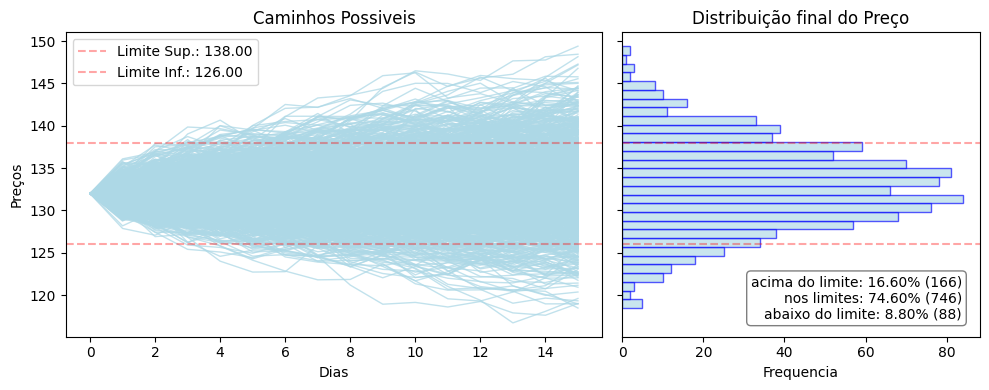

In [16]:
steps_per_year = 252
n_scenarios = 1000
n_years = dte/252  ## time to expiry in years

paths = gbm(n_years, n_scenarios, ann_mu, ann_sigma.iloc[-1], steps_per_year, S)
win_pct, loss_above, loss_bellow = plot_paths(paths[:(dte - 21)], ceiling=short_call_strike, floor=short_put_strike)

In [17]:
p = win_pct                          
R = roc                             
L = max_loss / credit_received       
                   

max_risk, kelly_fraction  = kelly_criterion(p, R, L, portfolio_size, multiplier)

print(f'Monte Carlo Win Rate: {win_pct:.2%}, Credit: {roc:.2%}')
print(f'Kelly Factor of total portfolio for this trade: {kelly_fraction:.2%} ')
print(f'Max Risk of this trade: R$ {max_risk:.2f}')

Monte Carlo Win Rate: 74.60%, Credit: 23.00%
Kelly Factor of total portfolio for this trade: 15.19% 
Max Risk of this trade: R$ 17.16


In [18]:
qty = math.floor(max_risk/max_loss)
print(f'Quantity of ICs to buy: {qty}')
iron_condor(options_chain_back, long_put_strike, short_put_strike, short_call_strike, long_call_strike, qty=qty)

Quantity of ICs to buy: 8
Position Risk: 16.64
Gain Range: 12.00
Credit Received/Max Profit: $7.36
Managed Take Profit: $3.83
Managed ROIC (net): 23.00%


(16.64, 12.0, 0.92, 0.4784000000000001, 0.22999999999999998, 3.0)

In [19]:
## Black and Scholes Prices 
# long_put_price = black_scholes(S, long_put_strike, T, r, ann_sigma.iloc[-1], 'p')
# short_put_price = black_scholes(S, short_put_strike, T, r, ann_sigma.iloc[-1], 'p')
# short_call_price = black_scholes(S, short_call_strike, T, r, ann_sigma.iloc[-1], 'c')
# long_call_price = black_scholes(S, long_call_strike, T, r, ann_sigma.iloc[-1], 'c')
# ironcondor_bs_price = long_put_price - short_put_price + short_call_price - long_call_price

# print(f'Long Put Strike {long_put_strike}: price {long_put_price:.2f}')
# print(f'Short Put Strike {short_put_strike}: price {short_put_price:.2f}')
# print(f'Short Call Strike {short_call_strike}: price {short_call_price:.2f}')
# print(f'Long Call Strike {long_call_strike}: price {long_call_price:.2f}')
# print(f'ATM Straddle: price {ironcondor_bs_price:.2f}')
# print(f'BS ROIC: {ironcondor_bs_price / (wing_width - ironcondor_bs_price):.2%}') 

# long_put_delta = delta(S, long_put_strike, T, r, ann_sigma.iloc[-1], 'p')
# short_put_delta = delta(S, short_put_strike, T, r, ann_sigma.iloc[-1], 'p')
# short_call_delta = delta(S, short_call_strike, T, r, ann_sigma.iloc[-1], 'c')
# long_call_delta = delta(S, long_call_strike, T, r, ann_sigma.iloc[-1], 'c')

# long_put_delta, short_put_delta, short_call_delta, long_call_delta

[Iron Condor](https://optionalpha.com/strategies/iron-condor)  
[Volatility Estimators - Portfolio Optimizer](https://portfoliooptimizer.io/blog/range-based-volatility-estimators-overview-and-examples-of-usage/)  
[Volatility Estimators - Hudson and Thames](https://www.mlfinlab.com/en/latest/feature_engineering/volatility_estimators.html)


